In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/jovyan/sz/practice/take_home_challenges/")
import helper_f
%matplotlib inline
from datetime import datetime

## 4 goals
1. find out country of the user
2. build a ML model to predict fraud
3. explain what variables differentiate two groups

In [2]:
country = pd.read_csv("IpAddress_to_Country.csv")
user = pd.read_csv("Fraud_Data.csv")

In [3]:
#basic exploration of user table
#1. find out null value percentage
for col in user.columns:
    print(col, " has: {}% null values".format(user[col].isnull().sum() / user.shape[0]))

#Good to know that no column has null values, now we map id by country

user_id  has: 0.0% null values
signup_time  has: 0.0% null values
purchase_time  has: 0.0% null values
purchase_value  has: 0.0% null values
device_id  has: 0.0% null values
source  has: 0.0% null values
browser  has: 0.0% null values
sex  has: 0.0% null values
age  has: 0.0% null values
ip_address  has: 0.0% null values
class  has: 0.0% null values


### Map ip_address to country
There are some ip addresses that have no map, and in that case, it is simply null.

In [4]:
user['country'] = user['ip_address'].map(lambda val: country.loc[(country.lower_bound_ip_address < val) & \
                                                    (country.upper_bound_ip_address > val), 'country'].values)
user['country'] = user['country'].map(lambda row: row[0] if len(row) > 0 else '')

In [5]:
#create a new feature purchase duration = purchase_time - signup_time in days
user['signup_time'] = user['signup_time'].apply(lambda row: datetime.strptime(row, "%Y-%m-%d %H:%M:%S"))
user['purchase_time'] = user['purchase_time'].apply(lambda row: datetime.strptime(row, "%Y-%m-%d %H:%M:%S"))
user['purchase_duration'] = user.apply(lambda x: (x['purchase_time'].to_pydatetime() - x['signup_time'].to_pydatetime()).days, axis = 1)

In [6]:
user.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,purchase_duration
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,52
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,0


In [26]:
#add these two columns 'device_id_count' and 'ip_count'
device = user.groupby(['device_id'])['user_id'].count().reset_index(name = 'device_id_count')
ip = user.groupby(['ip_address'])['user_id'].count().reset_index(name = 'ip_count')

In [30]:
user = pd.merge(user, device, how = 'inner', on = 'device_id')
user = pd.merge(user, ip, how = 'inner', on = 'ip_address')
user.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,purchase_duration,device_id_count,ip_count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,52,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,0,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,0,12,12
3,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,0,12,12
4,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,0,12,12


In [31]:
#check out number of unique values of each column
for col in user.columns:
    print("{} has {} unique values".format(col, len(user[col].unique())))

user_id has 151112 unique values
signup_time has 151112 unique values
purchase_time has 150679 unique values
purchase_value has 122 unique values
device_id has 137956 unique values
source has 3 unique values
browser has 5 unique values
sex has 2 unique values
age has 58 unique values
ip_address has 143512 unique values
class has 2 unique values
country has 182 unique values
purchase_duration has 120 unique values
device_id_count has 20 unique values
ip_count has 20 unique values


In [32]:
user.describe()

,user_id,purchase_value,age,ip_address,class,purchase_duration,device_id_count,ip_count
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000,151112.000000,151112.000000,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646,56.609799,1.684367,1.602719
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336,36.142085,2.616954,2.596240
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000,0.000000,1.000000,1.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000,25.000000,1.000000,1.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000,57.000000,1.000000,1.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000,88.000000,1.000000,1.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000,119.000000,20.000000,20.000000


### Exploratory data analysis with graphs using helper_f

we can see that these three varibles have very balanced distribution for each class of target variable

<Figure size 432x288 with 0 Axes>

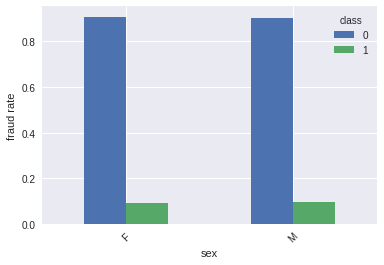

<Figure size 432x288 with 0 Axes>

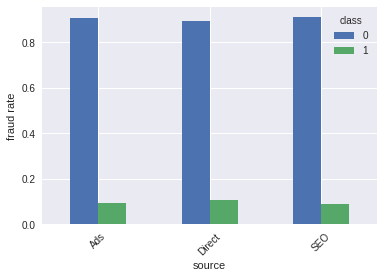

<Figure size 432x288 with 0 Axes>

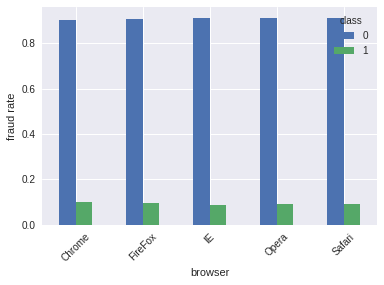

In [33]:
helper_f.plot_freq(columns=['sex','source','browser'], label= 'class', df=user, ylabel= 'fraud rate', rotation=True)

1. **purchase value**, we can see that for those types that are not fraud, most of purchases occur from 10 - 50<br>
2. **age**, most of fraud activities happen to age between 30 - 40

purchase_value


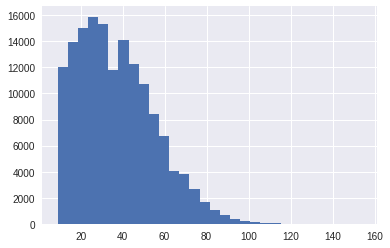

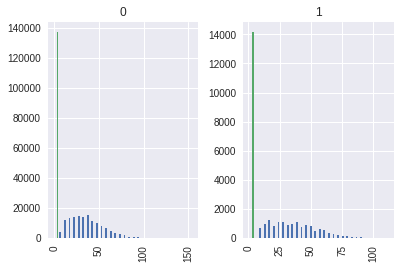

age


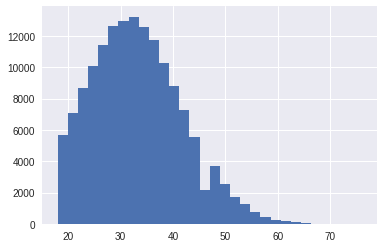

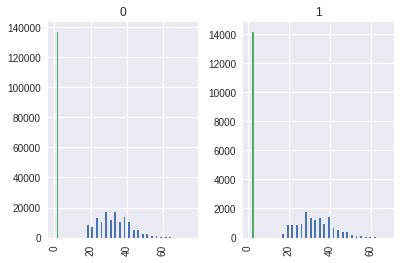

purchase_duration


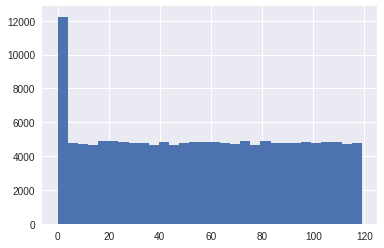

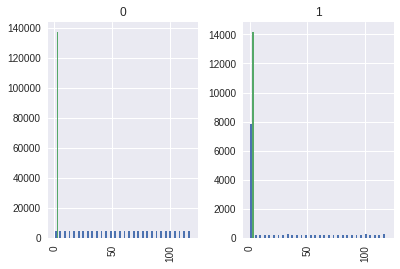

In [34]:
helper_f.plot_continuous(columns= ['purchase_value', 'age', 'purchase_duration'], label = 'class', df= user)

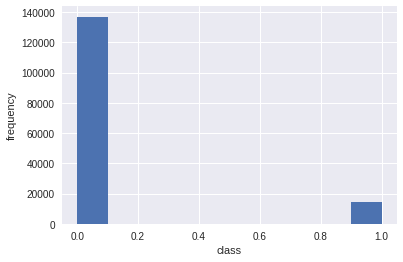

In [35]:
helper_f.plot_target('class',user)

### Build a machine learning model for prediction

In [36]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#drop these columns
to_drop = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address']
user.drop(to_drop, axis = 1, inplace=True)

#categorize purchase duration to short and long
user['purchase_duration'] = pd.cut(x = user['purchase_duration'], bins = 3, labels= ['short', 'medium','long'])

#encode these string columns to categorical values
to_encode = ['source', 'browser', 'sex','purchase_duration']
for col in to_encode:
    user[col] = le.fit_transform(user[col])

In [37]:
dummy_country = pd.get_dummies(user['country'])
user.drop(['country'], axis = 1, inplace = True)
user = pd.concat([user,dummy_country], axis = 1)

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#train test split
X_train, X_test, y_train, y_test = train_test_split(user.loc[:,user.columns != 'class'].values, \
        user['class'].values, test_size = 0.25)

In [41]:
#fit model and plot feature importance
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [43]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]

#print feature ranking
print("Feature ranking: ")
for f in range(user.loc[:, user.columns != 'class'].shape[1])[:10]:
    print("{}. feature {} {:.4f}".format(f+1, indices[f], importances[indices[f]]))

Feature ranking: 
1. feature 6 0.3327
2. feature 0 0.1837
3. feature 7 0.1704
4. feature 4 0.1356
5. feature 5 0.0590
6. feature 2 0.0320
7. feature 1 0.0247
8. feature 3 0.0134
9. feature 180 0.0042
10. feature 8 0.0027


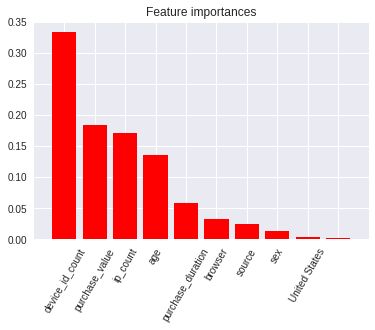

In [44]:
#map index and name
X = user.loc[:, user.columns != 'class']
names = {i: X.columns[i] for i in range(len(X.columns))}
idx_name_map = [names[idx] for idx in indices[:10]]
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices][:10], color="r", align="center")
plt.xticks(range(10), idx_name_map, rotation = 60)
plt.xlim([-1, 10])
plt.show()

Based on above feature importance plot, we can see that device_id_count and ip_count matter and they can be crucial in identifying fraudulent activities